In [ ]:
from IPython.display import clear_output
!pip install datasets
clear_output()

In [ ]:
import numpy as np
import tensorflow as tf
import cv2
from datasets import load_dataset
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import *
from keras.models import Model
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from collections import defaultdict
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
import os

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


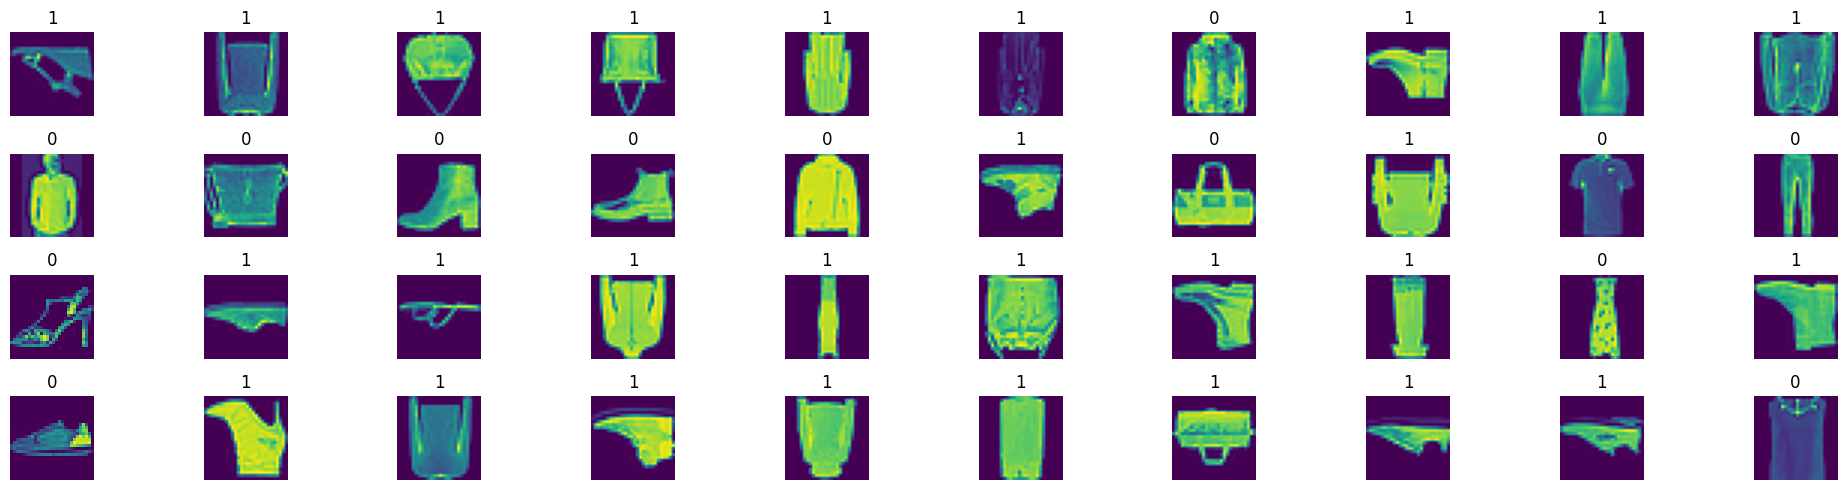

In [ ]:
class MNist_Fashion:
  def __init__(self, hugging_face_path='fashion_mnist', classes=10, class_names=None):
    self.mnist_fashion = load_dataset(hugging_face_path)
    self.classes = classes
    self.class_names = class_names

  def flip_vertical(self, subset='train'):
    combined_data = list(zip(self.mnist_fashion[subset]['image'], self.mnist_fashion[subset]['label']))
    sorted_data = sorted(combined_data, key=lambda x: x[1])
    images, labels = zip(*sorted_data)
    images = np.array(images)
    labels = np.zeros_like(labels)

    for i in range(len(np.unique(labels))):
      class_indices = np.where(np.array(labels) == i)[0]
      half_len = len(class_indices) // 2
      flip_indices = np.random.choice(class_indices, half_len, replace=False)
      for index in flip_indices:
          images[index] = np.flipud(images[index])
          labels[index] = 1
    return images, labels

  def load_dataset(self):
    self.images_train, self.labels_train = self.flip_vertical('train')
    self.images_test, self.labels_test = self.flip_vertical('test')

  def draw_sample_images(self, nrows=4, ncols=10, labels=False):
    total_image = self.images_train.shape[0]

    samples = np.random.choice(total_image, nrows*ncols)

    plt.figure(figsize=(20, 5))
    for i in range(nrows*ncols):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(self.images_train[samples[i]])
        if(labels):
            plt.title(self.labels_train[samples[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
mnistfashion = MNist_Fashion(hugging_face_path='fashion_mnist', classes=10, class_names=class_names)
mnistfashion.load_dataset()
mnistfashion.draw_sample_images(labels = True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                        

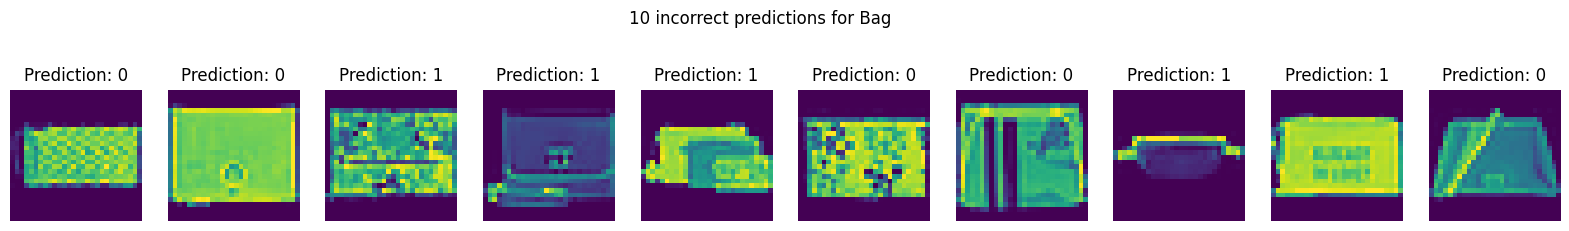

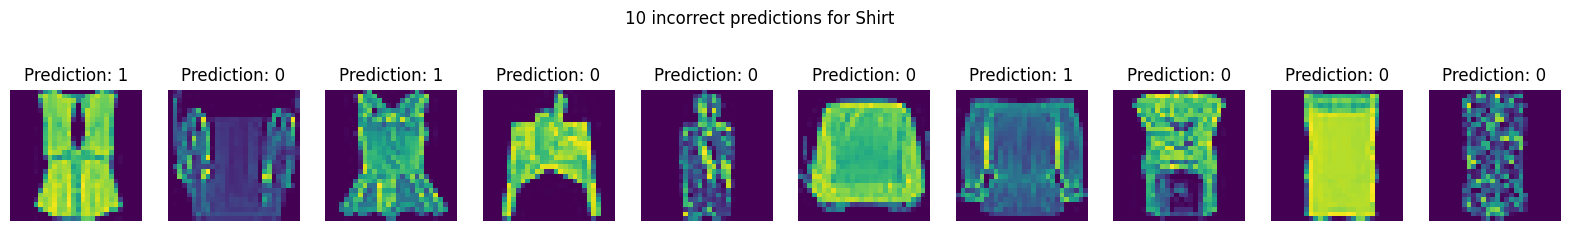

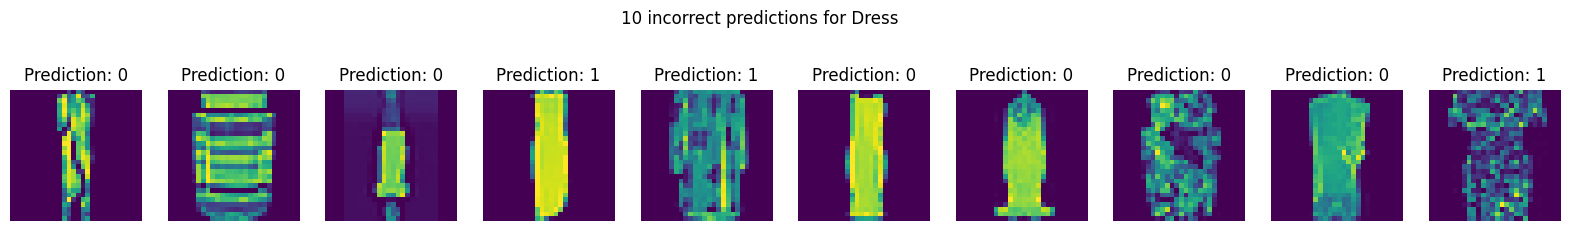

313/313 [==============================] - 2s 5ms/step - loss: 0.0250 - accuracy: 0.9906
Test Loss: 0.025000810623168945 - Test Accuracy: 0.9905999898910522


In [ ]:
class CNN_Classifier:
  def __init__(self, IMAGE_SIZE=(28, 28), CHANNEL=1, USE_PRETRAINED=False):
    self.IMAGE_SIZE = IMAGE_SIZE
    self.CHANNEL = CHANNEL
    self.USE_PRETRAINED = USE_PRETRAINED

  def build_model(self):
    model = tf.keras.Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(self.IMAGE_SIZE[0], self.IMAGE_SIZE[1], self.CHANNEL)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    self.model = model

  def training(self, mnistfashion=None, epochs=10, validation_split=0.2, batch_size=32, patience=3):
    early_stopping = EarlyStopping(
                                  monitor='val_loss',
                                  patience=patience,
                                  verbose=1,
                                  mode='min')
    model_checkpoint = ModelCheckpoint(
                                      filepath='/content/best.hdf5',
                                      save_weights_only=True,
                                      monitor='val_loss',
                                      mode='min',
                                      save_best_only=True,
                                      save_freq='epoch',
                                      verbose=1)

    data_shuffled, labels_shuffled = shuffle(mnistfashion.images_train, mnistfashion.labels_train, random_state=42)

    X_train, X_valid, y_train, y_valid = train_test_split(data_shuffled, labels_shuffled, shuffle=True, test_size=validation_split, random_state=42)
    self.history = self.model.fit(
        x=X_train,
        y=y_train,
        shuffle=True,
        epochs=epochs,
        validation_data=(X_valid, y_valid),
        batch_size=batch_size,
        callbacks=[early_stopping, model_checkpoint],
    )

  def evaluate(self, mnistfashion=None):
    print('\n===================== TEST SET =====================')
    self.model.load_weights('/content/best.hdf5')
    accuracies = {}
    incorrect_predictions = defaultdict(list)
    for i in range(mnistfashion.classes):
      start = i * len(mnistfashion.images_test) // mnistfashion.classes
      end = len(mnistfashion.images_test) // mnistfashion.classes
      images = mnistfashion.images_test[start:start+end]
      labels = mnistfashion.labels_test[start:start+end]

      predictions = self.model.predict(images, verbose=0)
      predictions = np.argmax(predictions, axis=1)
      accuracy = np.mean(predictions == labels)
      accuracies[mnistfashion.class_names[i]] = round(accuracy, 5)

      print(f'Class: {mnistfashion.class_names[i]}')
      print(classification_report(labels, predictions))
      print('\n')
      incorrect_indices = np.where(predictions != labels)[0]
      for index in incorrect_indices[:10]:
        incorrect_predictions[mnistfashion.class_names[i]].append((images[index], predictions[index]))

    sorted_categories = sorted(accuracies.items(), key=lambda x: x[1])[:3]
    for category, _ in sorted_categories:
        fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 3))
        fig.suptitle(f'10 incorrect predictions for {category}')
        incorrect_images = incorrect_predictions[category]
        for i, (image, prediction) in enumerate(incorrect_images):
            ax = axes[i]
            ax.imshow(image)
            ax.set_title(f'Prediction: {prediction}')
            ax.axis('off')
        plt.show()

    test_acc = self.model.evaluate(mnistfashion.images_test, mnistfashion.labels_test)
    print(f'Test Loss: {test_acc[0]} - Test Accuracy: {test_acc[1]}')



cnn_classifier = CNN_Classifier(USE_PRETRAINED=False)
cnn_classifier.build_model()
cnn_classifier.model.summary()
cnn_classifier.training(mnistfashion=mnistfashion,
                             epochs=100,
                             validation_split=0.2,
                             batch_size=64,
                             patience=3)
cnn_classifier.evaluate(mnistfashion)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 56, 56, 1)         0         
 D)                                                              
                                                                 
 conv1 (Conv2D)              (None, 28, 28, 32)        288       
                                                                 
 conv1_bn (BatchNormalizati  (None, 28, 28, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 28, 28, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 28, 28, 32)        288   

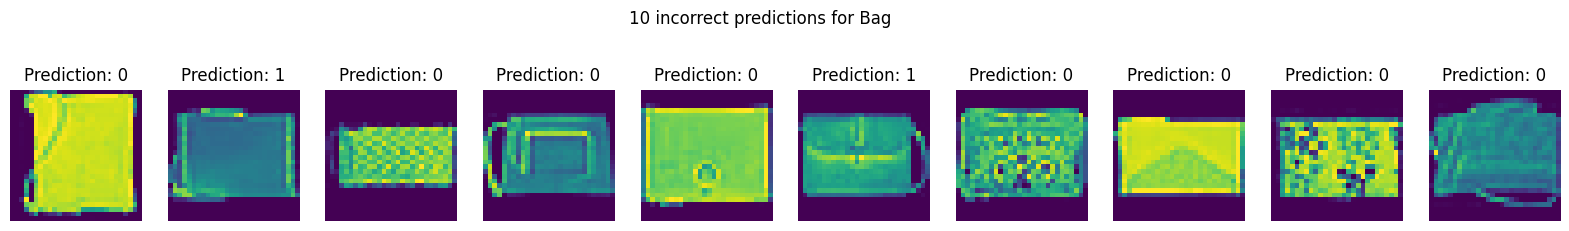

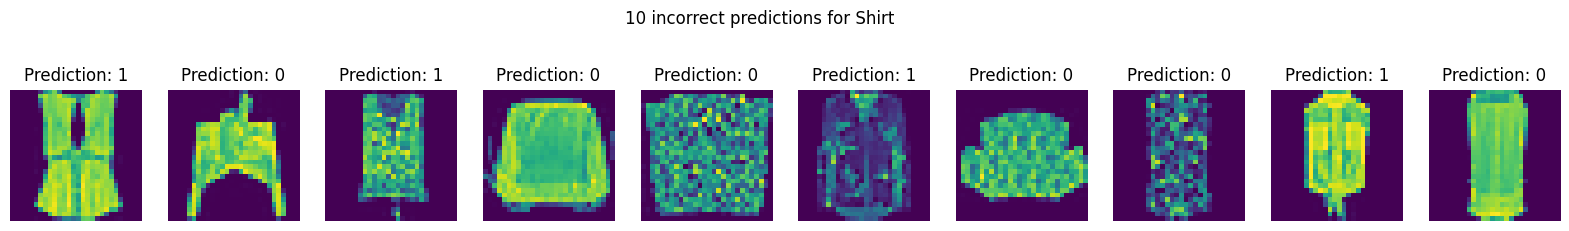

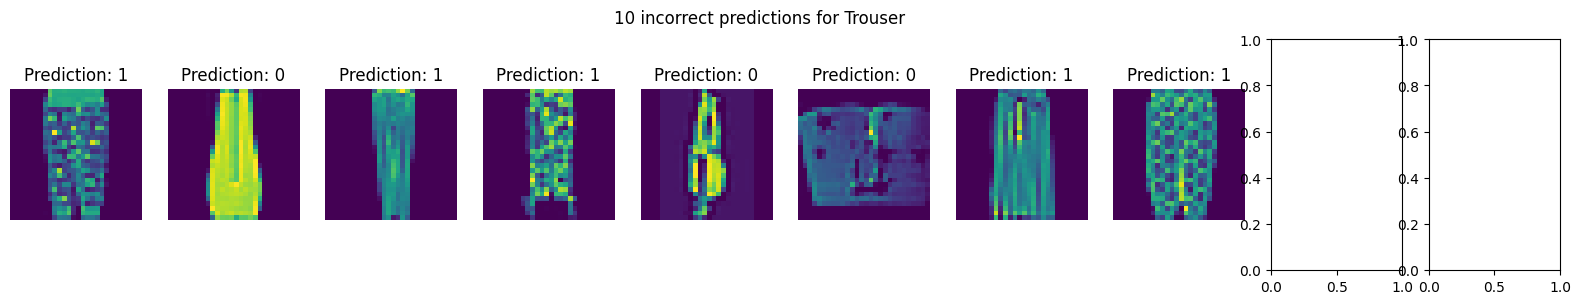

313/313 [==============================] - 2s 7ms/step - loss: 0.0300 - accuracy: 0.9903
Test Loss: 0.02995244972407818 - Test Accuracy: 0.9902999997138977


In [ ]:
class MobileNet_Clasifier(CNN_Classifier):
  def __init__(self, IMAGE_SIZE=(28, 28), CHANNEL=1, USE_PRETRAINED=False):
    super().__init__()

  def build_model(self):
    input_layer = Input(shape=(self.IMAGE_SIZE[0], self.IMAGE_SIZE[1], self.CHANNEL))
    resized_input = UpSampling2D(size=(2, 2))(input_layer)
    base_model = MobileNet(weights='imagenet' if self.USE_PRETRAINED else None,
                            include_top=False,
                            input_tensor=resized_input)
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    output_layer = Dense(2, activation='softmax')(x)
    self.model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    self.model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

mobilenet_classifier = MobileNet_Clasifier(USE_PRETRAINED=False)
mobilenet_classifier.build_model()
mobilenet_classifier.model.summary()
mobilenet_classifier.training(mnistfashion=mnistfashion,
                             epochs=100,
                             validation_split=0.2,
                             batch_size=64,
                             patience=5)
mobilenet_classifier.evaluate(mnistfashion)